In [1]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


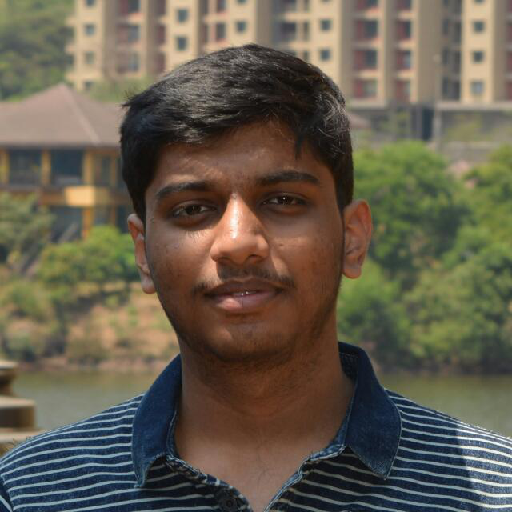

In [2]:
height = 512
width = 512

content_image_path = 'me.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

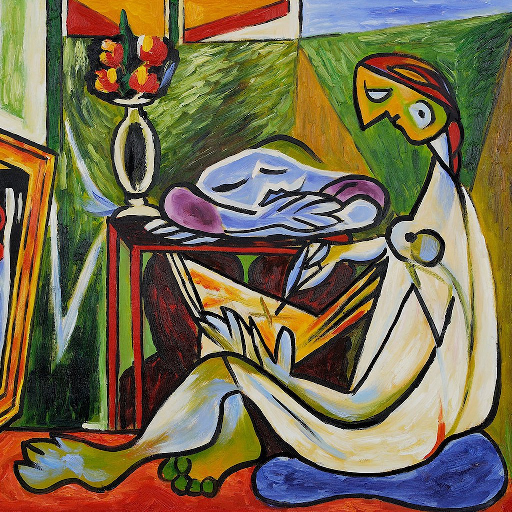

In [3]:
style_image_path = 'picasso.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

In [4]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [5]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

In [6]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [7]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

In [8]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [9]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 64, 64, 512) dtype=float32>,
 'b

In [10]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [11]:
loss = backend.variable(0.)

In [12]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

In [13]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [14]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [15]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [16]:
grads = backend.gradients(loss, combination_image)

In [17]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [18]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1.41816e+11
Iteration 0 completed in 751s
Start of iteration 1
Current loss value: 9.48686e+10
Iteration 1 completed in 765s
Start of iteration 2
Current loss value: 7.67736e+10
Iteration 2 completed in 777s
Start of iteration 3
Current loss value: 6.79511e+10
Iteration 3 completed in 804s
Start of iteration 4
Current loss value: 6.2657e+10
Iteration 4 completed in 741s
Start of iteration 5
Current loss value: 5.93704e+10
Iteration 5 completed in 752s
Start of iteration 6
Current loss value: 5.71905e+10
Iteration 6 completed in 828s
Start of iteration 7
Current loss value: 5.58921e+10
Iteration 7 completed in 767s
Start of iteration 8
Current loss value: 5.48403e+10
Iteration 8 completed in 736s
Start of iteration 9
Current loss value: 5.40605e+10
Iteration 9 completed in 724s


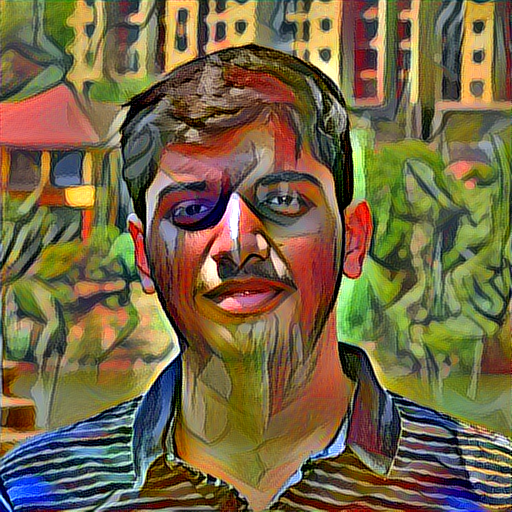

In [19]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)